# Recreate SPRING vizualisation of control epithelial cells   
Save graph and auxiliary files to SPRING directory for interactive exploration.  
Allow the graph to fully relax using the browser version of force layout (empirically works best but slow).  
Save xy coordinates in SPRING (browser version).  
Load xy coordinates from the SPRING directory for further use within the notebook.

In [1]:
import os,sys
import datetime

### Import scanpy

In [2]:
import scanpy.api as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.3.4 anndata==0.6.13 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
Memory usage: current 0.17 GB, difference +0.17 GB


### Import my utility functions and import statements from github

In [3]:
"""# This cell is run once to download my custom functions and import statements from github

!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
    
# github doesn't seem to have an option to download a specific version of the repo from the history.
# So I download my utility functions and save the download time by appending it to the directory name.
# These utility functions to be shared together with the notebook.

toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
newname = "utility_functions_%s"%toappend
print(newname)


# rename the py file with utility functions
os.rename("utility_functions",newname)"""

'# This cell is run once to download my custom functions and import statements from github\n\n!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions\n    \n# github doesn\'t seem to have an option to download a specific version of the repo from the history.\n# So I download my utility functions and save the download time by appending it to the directory name.\n# These utility functions to be shared together with the notebook.\n\ntoappend = datetime.datetime.now().strftime(\'%y%m%d_%Hh%M\')\nnewname = "utility_functions_%s"%toappend\nprint(newname)\n\n\n# rename the py file with utility functions\nos.rename("utility_functions",newname)'

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190425_11h32"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import
import rz_utility_spring as srz

python version: 3.6.7


## Load data and place into an annData object

In [5]:
!ls data_from_geo

cell_info_8594x25.tsv         injury_barcodes.tsv
control_barcodes.tsv          injury_genes.tsv
control_genes.tsv             injury_loom.loom
control_loom.loom             injury_matrix.mtx
control_matrix.mtx            raw_counts_8594x27998.mtx
gene_names_alphabetically.txt


In [6]:
obspath = 'data_from_geo/cell_info_8594x25.tsv'
countpath = 'data_from_geo/raw_counts_8594x27998.mtx'
genepath = 'data_from_geo/gene_names_alphabetically.txt'

In [7]:
# load cell info
obs = pd.read_csv(obspath,sep='\t',index_col=0)
print(obs.shape)
obs.head()

(8594, 25)


,barcode,condition,total_counts,pass_quality_filters,inj_epithelial,ctr_epithelial,excluded_as_immune_or_mesench,class,population,phase,...,x_control,y_control,x_class3_exploded,y_class3_exploded,x_control_injured,y_control_injured,x_class1_CTR_cell_cyc_removed,y_class1_CTR_cell_cyc_removed,x_class1_INJ_cell_cyc_removed,y_class1_INJ_cell_cyc_removed
0,AAACCTGAGTGCTGCC-1,control,2787,True,False,True,False,class3,ctr_DEEx,G1,...,783.705500,-377.074709,1082.172898,-266.303304,709.78614,-325.505019,NaN,NaN,NaN,NaN
1,AAACCTGAGTGGGTTG-1,control,3325,True,False,True,False,class3,ctr_upper_IEE,G1,...,709.612642,-429.409941,854.230866,-454.025809,529.15516,-471.961493,NaN,NaN,NaN,NaN
2,AAACCTGCAAGTCTAC-1,control,1781,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCTGCAATCTGCA-1,control,3468,True,False,False,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCTGCACGGTGTC-1,control,1745,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# load counts
adata = sc.read_mtx(countpath)
print(adata.shape)

# add genes (annotation of variables)
adata.var['genes'] = np.loadtxt(genepath,dtype=str)

# make sure var names are genes
adata.var_names = adata.var['genes'].values

# add obs (annotation of observations)
adata.obs = obs

# make sure index is unique AND a string
adata.obs_names_make_unique()
adata.obs_names = adata.obs_names.astype(str)

(8594, 27998)


## Scale (normalize) data

In [9]:
# turn into counts per 10k
print(adata.X[:5,:].sum(axis=1))
print()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
print(adata.X[:5,:].sum(axis=1))

[[2787.]
 [3325.]
 [1781.]
 [3468.]
 [1745.]]

[[10000.   ]
 [10000.   ]
 [10000.001]
 [10000.   ]
 [ 9999.999]]


## SPRING project directory to use

In [10]:
project_dir = "SPRING_dev-master/datasets/Sharir_et_al_2019/"

## Prepare kNN graph

In [11]:
# out of all cells in adata, select only those you want to plot
# make a copy of the adata object
cell_mask = adata.obs['ctr_epithelial'].astype(bool).values
print(cell_mask.sum())
cdata = adata[cell_mask].copy() # all cells in this case

# chose a name for the spring subplot
plot_name = 'control_epithelial'

# chose dataset for selecting abundant and variable genes
# here I use linear counts-per-10k
E = cdata.X

# in an attempt to be more organized I keep a log of spring parameter and intermediate data structures used in
# the form of an unstructured annotation as part of an AnnData object.
srz.start_spring_params(cdata,plot_name)

# print the newly created dictionary, also define a variable to access it faster:
pdict = cdata.uns['spring_params'][plot_name]
pdict

2349


{'k': 5,
 'cell_mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'min_counts': 3,
 'min_cells': 3,
 'base_ix': array([   0,    1,    2, ..., 2346, 2347, 2348]),
 'num_pc': 20,
 'plot_name': 'control_epithelial'}

In [12]:
# overwrite some of the parameters for SPRING
pdict['cell_mask'] = cell_mask
pdict['k'] = 10
pdict['min_counts'] = 6 
pdict['min_cells'] = 3
pdict

{'k': 10,
 'cell_mask': array([ True,  True, False, ..., False, False, False]),
 'min_counts': 6,
 'min_cells': 3,
 'base_ix': array([   0,    1,    2, ..., 2346, 2347, 2348]),
 'num_pc': 20,
 'plot_name': 'control_epithelial'}

### Filter genes

In [13]:
# avoid genes starting with
toavoid = ['mt-','Rps','Rpl','Mrpl','Mrps']
for i in toavoid:
    print(i)
    print([g for g in adata.var_names if g.startswith(i)])
    print()
    print()

mt-
['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']


Rps
['Rps10', 'Rps11', 'Rps12', 'Rps12-ps3', 'Rps13', 'Rps14', 'Rps15', 'Rps15a', 'Rps16', 'Rps17', 'Rps18', 'Rps18-ps3', 'Rps19', 'Rps19bp1', 'Rps2', 'Rps2-ps6', 'Rps20', 'Rps21', 'Rps23', 'Rps24', 'Rps25', 'Rps26', 'Rps26-ps1', 'Rps27', 'Rps27a', 'Rps27l', 'Rps27rt', 'Rps28', 'Rps29', 'Rps3', 'Rps3a1', 'Rps4x', 'Rps5', 'Rps6', 'Rps6ka1', 'Rps6ka2', 'Rps6ka3', 'Rps6ka4', 'Rps6ka5', 'Rps6ka6', 'Rps6kb1', 'Rps6kb2', 'Rps6kc1', 'Rps6kl1', 'Rps7', 'Rps8', 'Rps9', 'Rpsa']


Rpl
['Rpl10', 'Rpl10-ps3', 'Rpl10a', 'Rpl10l', 'Rpl11', 'Rpl12', 'Rpl13', 'Rpl13-ps3', 'Rpl13a', 'Rpl13a-ps1', 'Rpl14', 'Rpl15', 'Rpl17', 'Rpl18', 'Rpl18a', 'Rpl19', 'Rpl21', 'Rpl21-ps4', 'Rpl22', 'Rpl22l1', 'Rpl23', 'Rpl23a', 'Rpl23a-ps3', 'Rpl24', 'Rpl26', 'Rpl27', 'Rpl27-ps3', 'Rpl27a', 'Rpl28', 'Rpl29', 'Rpl3', 'Rpl30', 'Rpl31', 'Rpl32', 'Rpl34', 'Rpl35', 'Rpl35a', 'Rpl36', 'Rp

In [14]:
# genes to exclude:
exclude_gene_names = []
for j in toavoid:
    exclude_gene_names.append([i for i in adata.var_names if i.startswith(j)])
exclude_gene_names = rz.flatten_list_of_lists(exclude_gene_names)
pdict['gene_names_excluded'] = exclude_gene_names
print('%d genes excluded based on name'%len(exclude_gene_names))

# filter on abundance:
pdict['abundant_gene_mask'] = srz.filter_abund_genes(
                                                     E,
                                                     pdict['min_counts'],
                                                     pdict['min_cells']
                                                    )

203 genes excluded based on name
6151 genes passing abundance filter


In [15]:
# combine gene filters so far
undesired = list(pdict['gene_names_excluded'])+\
            list(cdata.var_names[~pdict['abundant_gene_mask']])

print(len(undesired))
undesired = list(set(undesired))
print(len(undesired))

# boolean mask
combmask = ~np.in1d(cdata.var_names,undesired)
print(combmask.sum(),'surviving genes so far')

22050
22031
5967 surviving genes so far


In [16]:
# calculate v score (Klein et al., 2015, see equation S4 and S13) for all non-zero genes
isexpr = np.array(E.sum(axis=0))[0]>0
print('%d genes with non-zero expression'%sum(isexpr))
pdict['v_score_dict'] = srz.vscores(E[:,isexpr])

16853 genes with non-zero expression


In [17]:
# get genes above mode, i.e. any that can be considered variable
gabmod = cdata.var_names[isexpr][pdict['v_score_dict']['var_gene_mask']]
print(len(gabmod),'variable genes')

9618 variable genes


In [18]:
# update combmask:
mvar = np.in1d(cdata.var_names,gabmod)
print(mvar.sum())
combmask = combmask&mvar
print(combmask.sum(),'abundant and variable genes')

9618
4205 abundant and variable genes


In [19]:
# if filtering on correlation, get gene-gene correlation
corx = E[:,combmask]
print(corx.shape)
corx = srz.sparse_corrcoef(corx.T)
corx = np.array(corx)

(2349, 4205)
0.10 min.


In [20]:
# select correlation filters (largely arbitrary), as described in Klein et al. 2015
genes_at_least = 3 #at least this number of genes correlated to any other gene
corr_at_least = 0.1 #with a Pearson correlation coefficient at least this large

################################################################################

# genes passing correlation filter
cormask = (abs(corx)>corr_at_least).sum(axis=0)>genes_at_least #"more than" as one instance is the gene itself with r=1
print((~cormask).sum(), 'genes to exclude based on correlation')

# combine filter
pdict['genes_used'] = cdata.var_names[combmask][cormask]
print(len(pdict['genes_used']),'genes surviving all filters')

1959 genes to exclude based on correlation
2246 genes surviving all filters


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


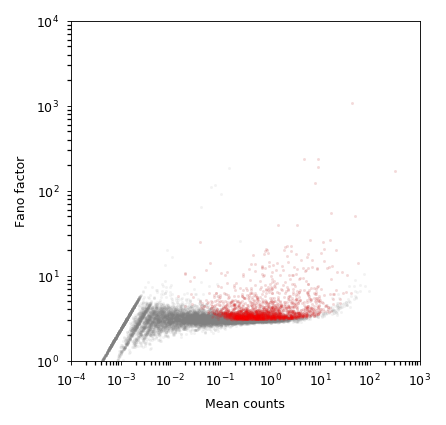

In [21]:
# plot a fano factor vs mean plot with genes used further colored in red
ff = pdict['v_score_dict']['ff_gene']
mu = pdict['v_score_dict']['mu_gene']
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])

# check scatter
s = 2
plt.figure(figsize=(3,3))
plt.scatter(mu,ff,lw=0,color='0.5',alpha=0.1,s=s)
plt.scatter(mu[finalmask[isexpr]],ff[finalmask[isexpr]],lw=0,color='r',alpha=0.1,s=s)
plt.xscale('log');
plt.yscale('log');
plt.xlim(0.0001,1000)
plt.ylim(1,10000)
plt.xlabel('Mean counts')
plt.ylabel('Fano factor');

### Prepare data for PCA

In [22]:
pdict['genes_used'] = cdata.var_names[finalmask]
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])

In [23]:
# leave only genes defined as variable, overwrite
print(cdata.shape)
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])
cdata = cdata[:,finalmask]
print(cdata.shape)

(2349, 27998)
(2349, 2246)


In [24]:
# zscore
sc.pp.scale(cdata)
Z = cdata.X

In [25]:
# find the number of non-random PCs
d = srz.find_num_pc(Z,start_pc=50,sparse=False)

calculating the first 50 observed eigenvalues...
calculating the random eigenvalues for 10 rounds of shuffling...
1 	 36 	 0.02 min.
calculating the first 100 observed eigenvalues...
calculating the random eigenvalues for 10 rounds of shuffling...
2 	 37 	 0.05 min.
3 	 37 	 0.08 min.
4 	 37 	 0.10 min.
5 	 38 	 0.12 min.
6 	 37 	 0.14 min.
7 	 37 	 0.17 min.
8 	 37 	 0.19 min.
9 	 38 	 0.21 min.
10 	 38 	 0.24 min.


In [26]:
# record results to log:
pdict['num_pc'] = d['num_pc']
pdict['eigenvectors'] = d['pca'].components_
pdict['eigenvalues'] = d['pca'].explained_variance_


print(d['num_pc'])

37


In [27]:
# apply dimensionality reduction on Z (get principle components)
# note, that eigenvalues can be calculated for base_ix only when applying batch correction
# make sure to provide a dense matrix Z

P = pdict['eigenvectors'][:pdict['num_pc'],:].dot(Z.T).T
print(P.shape)

(2349, 37)


In [28]:
# Place the principle component data into an AnnData object to use scanpynian functions downstream
P = AnnData(P)

# get kNN graph
# ignore the error message: https://github.com/lmcinnes/umap/issues/87
k = pdict['k']
print(k, 'neighbors')
sc.pp.neighbors(P,k,use_rep='X')

# draw force-directed graph. Not great, nodes need to relax further in interactive spring mode
sc.tl.draw_graph(P, layout='fa')

10 neighbors
computing neighbors


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:04.14)
drawing single-cell graph using layout "fa"
    finished (0:00:13.20)


In [29]:
# continuous per-cell metadata
contvars = ['total_counts']

# categorical
catvars = ['condition','class','population','phase','class2_3_like',
           'source_sink_for_pseudotime']

In [30]:
# export_spring_plot was complaining about the data format, force the right one
for contvar in contvars:
    P.obs[contvar] = cdata.obs[contvar].astype(float).values
    
for catvar in catvars:
    P.obs[catvar] = cdata.obs[catvar].astype(str).values

In [35]:
plot_name = pdict['plot_name']
print(plot_name)
srz.export_spring_plot(P,
                       project_dir,
                       plot_name,
                       
                       # specify the normalized expression values
                       # this is solely to calculate where the default saturation
                       # of gene expression is in the interactive explorer
                       E = adata[cell_mask].X.tocsc(), # tocsc() super important here
                       gene_list = adata.var_names.values,
                       cell_groupings=catvars,
                       custom_color_tracks=contvars,
                      )

control_epithelial
Writing subplot to SPRING_dev-master/datasets/Sharir_et_al_2019/control_epithelial/


In [36]:
# the function "srz.export_spring_plot" needs to be updated to properly save the cell filter. To do.
# for now I use a hack and save manually using the code in this cell.

subplot_dir = project_dir+'/'+plot_name + '/'
cell_ix = np.arange(len(pdict['cell_mask']))[pdict['cell_mask']]  
np.savetxt(subplot_dir + 'cell_filter.txt', cell_ix, fmt='%i')
np.save(subplot_dir + 'cell_filter.npy', cell_ix)

In [37]:
#save plot parameters
rz.save_stuff(path=project_dir+'/'+plot_name+'/params',stuff=pdict)

# Example of interacting with SPRING colortracks back and forth: change colors of classes

In [38]:
cg = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')
catcolors = {key:value['label_list'] for key,value in cg.items()}
color_dict = {key:value['label_colors'] for key,value in cg.items()}

# overwrite colors as desired
color_dict['population'] = {
'ctr_AMB_dist': '#cdceca',
'inj_AMB_dist': '#cdceca',
'ctr_AMB_prox': '#a0a2a1',
'inj_AMB_prox': '#a0a2a1',
'ctr_G2_M': '#344683',
'inj_G2_M': '#344683',
'ctr_OSR': '#b9938f',
'inj_OSR': '#b9938f',
'ctr_M_G1': '#607dac',
'inj_M_G1': '#607dac',
'ctr_ISR_SI': '#eb4034',
'inj_ISR_SI': '#eb4034',
'ctr_S': '#a8bad4',
'inj_S': '#a8bad4',
'ctr_SI': '#513230',
'inj_SI': '#513230',
'ctr_OEE_1': '#eddd00',
'inj_OEE_1': '#eddd00',
'ctr_DEEx': '#948f35',
'inj_DEEx': '#948f35',
'ctr_OEE_2': '#df9445',
'inj_OEE_2': '#df9445',
'ctr_pre_AMB': '#6c6d6a',
'inj_pre_AMB': '#6c6d6a',
'ctr_upper_IEE': '#302651',
'inj_upper_IEE': '#302651',
'ctr_OEE_IEE': '#a64a03',
'inj_OEE_IEE': '#a64a03',
'ctr_VEE': '#773579',
'inj_VEE': '#773579'}

color_dict['class'] = {
    'class1':'#21267f',
    'class2':'#666666',
    'class3':'#b2361f'
}


color_dict['class2_3_like'] = {
'ctr_AMB_dist_like': '#cdceca',
'ctr_AMB_prox_like': '#a0a2a1',
'ctr_G2_M_like': '#344683',
'ctr_OSR_like': '#b9938f',
'ctr_M_G1_like': '#607dac',
'ctr_ISR_SI_like': '#eb4034',
'ctr_S_like': '#a8bad4',
'ctr_SI_like': '#513230',
'ctr_OEE_1_like': '#eddd00',
'ctr_DEEx_like': '#948f35',
'ctr_OEE_2_like': '#df9445',
'ctr_pre_AMB_like': '#6c6d6a',
'ctr_upper_IEE_like': '#302651',
'ctr_OEE_IEE_like': '#a64a03',
'ctr_VEE_like': '#773579'
}

srz.overwrite_cell_groupings(project_dir+plot_name,catcolors,colordd=color_dict)

# Load coordinates and plot scatter

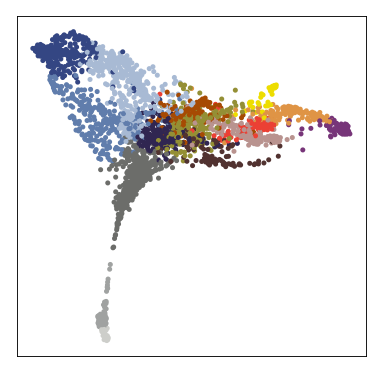

In [40]:
xy = pd.read_csv(project_dir+plot_name+'/coordinates.txt',header=None, index_col=0)
x = xy[1]
y = -xy[2] # y is flipped for some reason

plt.figure(figsize=(3,3))

color = [color_dict['population'][i] for i in catcolors['population']]

plt.scatter(x,y,color=color,s=2)
plt.xticks([])
plt.yticks([])
plt.show()